In [2]:
from ben_notebook_functions import *
import warnings
warnings.filterwarnings("ignore")
import cartopy.geodesic as cgeo
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
import datetime
import ipdb

In [1]:
cd ..

/home/users/cornkle/pythonWorkspace/proj_CEH


In [6]:
stash_dict={"sm":"STASH_m01s08i223",
            "lhfx":"STASH_m01s03i234",
            "shfx":"STASH_m01s03i217",
            "t2":"STASH_m01s03i236",
            "q2":"STASH_m01s03i237",
            "lw_nsfc":"STASH_m01s02i201",
            "sw_nsfc":"STASH_m01s01i201",
            "olr" : "STASH_m01s02i205",
            "u10" : "STASH_m01s03i225_2",
            "v10" : "STASH_m01s03i226_2"
           }

In [34]:
### FUNCTION FOR LOADING IN RAW DATA FILES - not actually used in this script, included as example.
def load_file(sim,date,hour,file_list,var):
    date_str="2006%02d%02d" % (date.month,date.day)
    hour=hour-1 #filenames are 1 hour BEHIND data timestamp
    date_str2=date_str
    date2 = date
    date_prev = date
    date_str_prev = date_str

    if (sim == 'sens') & (hour <= 5):
        date = date - datetime.timedelta(days=1)
        date_str = "2006%02d%02d" % (date.month,date.day)
        date_str2 = date_str
   
    ### this accesses day 2 of sensitivity runs
    if hour>23: # this accesses day 2 of sensitivity runs
        hour = hour-24
        if sim == "control":
            print('Control is continuous simulation, hour has to be <=23')
            return
        if (hour > 5):
            date2 = date + datetime.timedelta(days=1)
            date_str2 = "2006%02d%02d" % (date2.month,date2.day)
            date_str_prev = date_str2
        if (hour <= 5):
            date = date - datetime.timedelta(days=1)
            date_str = "2006%02d%02d" % (date.month,date.day)
            date_prev = date_prev + datetime.timedelta(days=1)
            date_str_prev = "2006%02d%02d" % (date_prev.month,date_prev.day)

    if sim=="sens":
        #root_str="/gws/nopw/j04/lmcs/filtered_soil_moisture_runs/u-da520/20060725T0500Z/Sahel/4km/RA3/um/"
        
        root_str=glob.glob("/gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/{}T0600Z/*/{}T0600Z/Sahel/1p5km/RA3/um/".format(date_str,date_str2))[0]
    elif sim=="control":
        root_str="/gws/nopw/j04/lmcs/u-cy045_control_run/u-cy045/{}T0000Z/Sahel/1p5km/RA3/um/".format(date_str)

    #print('Reading', root_str+"{}_{}_T{:02d}.nc".format(file_list,date_str_prev,hour))

    if file_list=="sensible_hfx_control":
        data=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/sensible_heat_fluxes/{}_sensible_heat_flux.nc".format(date_str2))["surface_upward_sensible_heat_flux"
        ].sel(longitude=slice(348,378),latitude=slice(9,19)).isel(time=slice(hour,hour+1)) # Sahel - time slice necessary to keep length 1 time axis.
        return data.rename({"longitude":"lon","latitude":"lat"})

    
    # elif sim=="sens" and date_str==date_prev and hour==5:
    #     data=xr.open_dataset("/gws/nopw/j04/lmcs/bmaybee/Filtered_SM_initialisations/{}_05Z_SM_filter_wg_mcs.nc".format(date_str))[var].sel(
    #                         grid_longitude_t=slice(348,378),grid_latitude_t=slice(9,19)).isel(ATM_SOIL=0)
    #     return data.rename({"grid_longitude_t":"lon","grid_latitude_t":"lat"})
            
    else:
        data=xr.open_dataset(root_str+"{}_{}_T{:02d}.nc".format(file_list,date_str_prev,hour))[var].sel(
                        grid_longitude_t=slice(348,380),grid_latitude_t=slice(8,28)) # Very big area, but crucially avoids all coastlines
        data=data.sel(grid_longitude_t=slice(348,378),grid_latitude_t=slice(9,19)) # RESTRICT TO CORE SAHEL
        print('Reading', root_str+"{}_{}_T{:02d}.nc".format(file_list,date_str_prev,hour))
        if file_list=="soil_moistures":
            data=data.isel(ATM_SOIL=0)
        try:
            data=data.isel(height_1_5m=0)
        except:
            pass
            
    return data.rename({"grid_longitude_t":"lon","grid_latitude_t":"lat"})

Reading /gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/20060827T0600Z/u-de722/20060827T0600Z/Sahel/1p5km/RA3/um/surface_vars_20060827_T18.nc
Reading /gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/20060826T0600Z/u-de721/20060827T0600Z/Sahel/1p5km/RA3/um/surface_vars_20060827_T18.nc
Reading /gws/nopw/j04/lmcs/u-cy045_control_run/u-cy045/20060827T0000Z/Sahel/1p5km/RA3/um/surface_vars_20060827_T18.nc


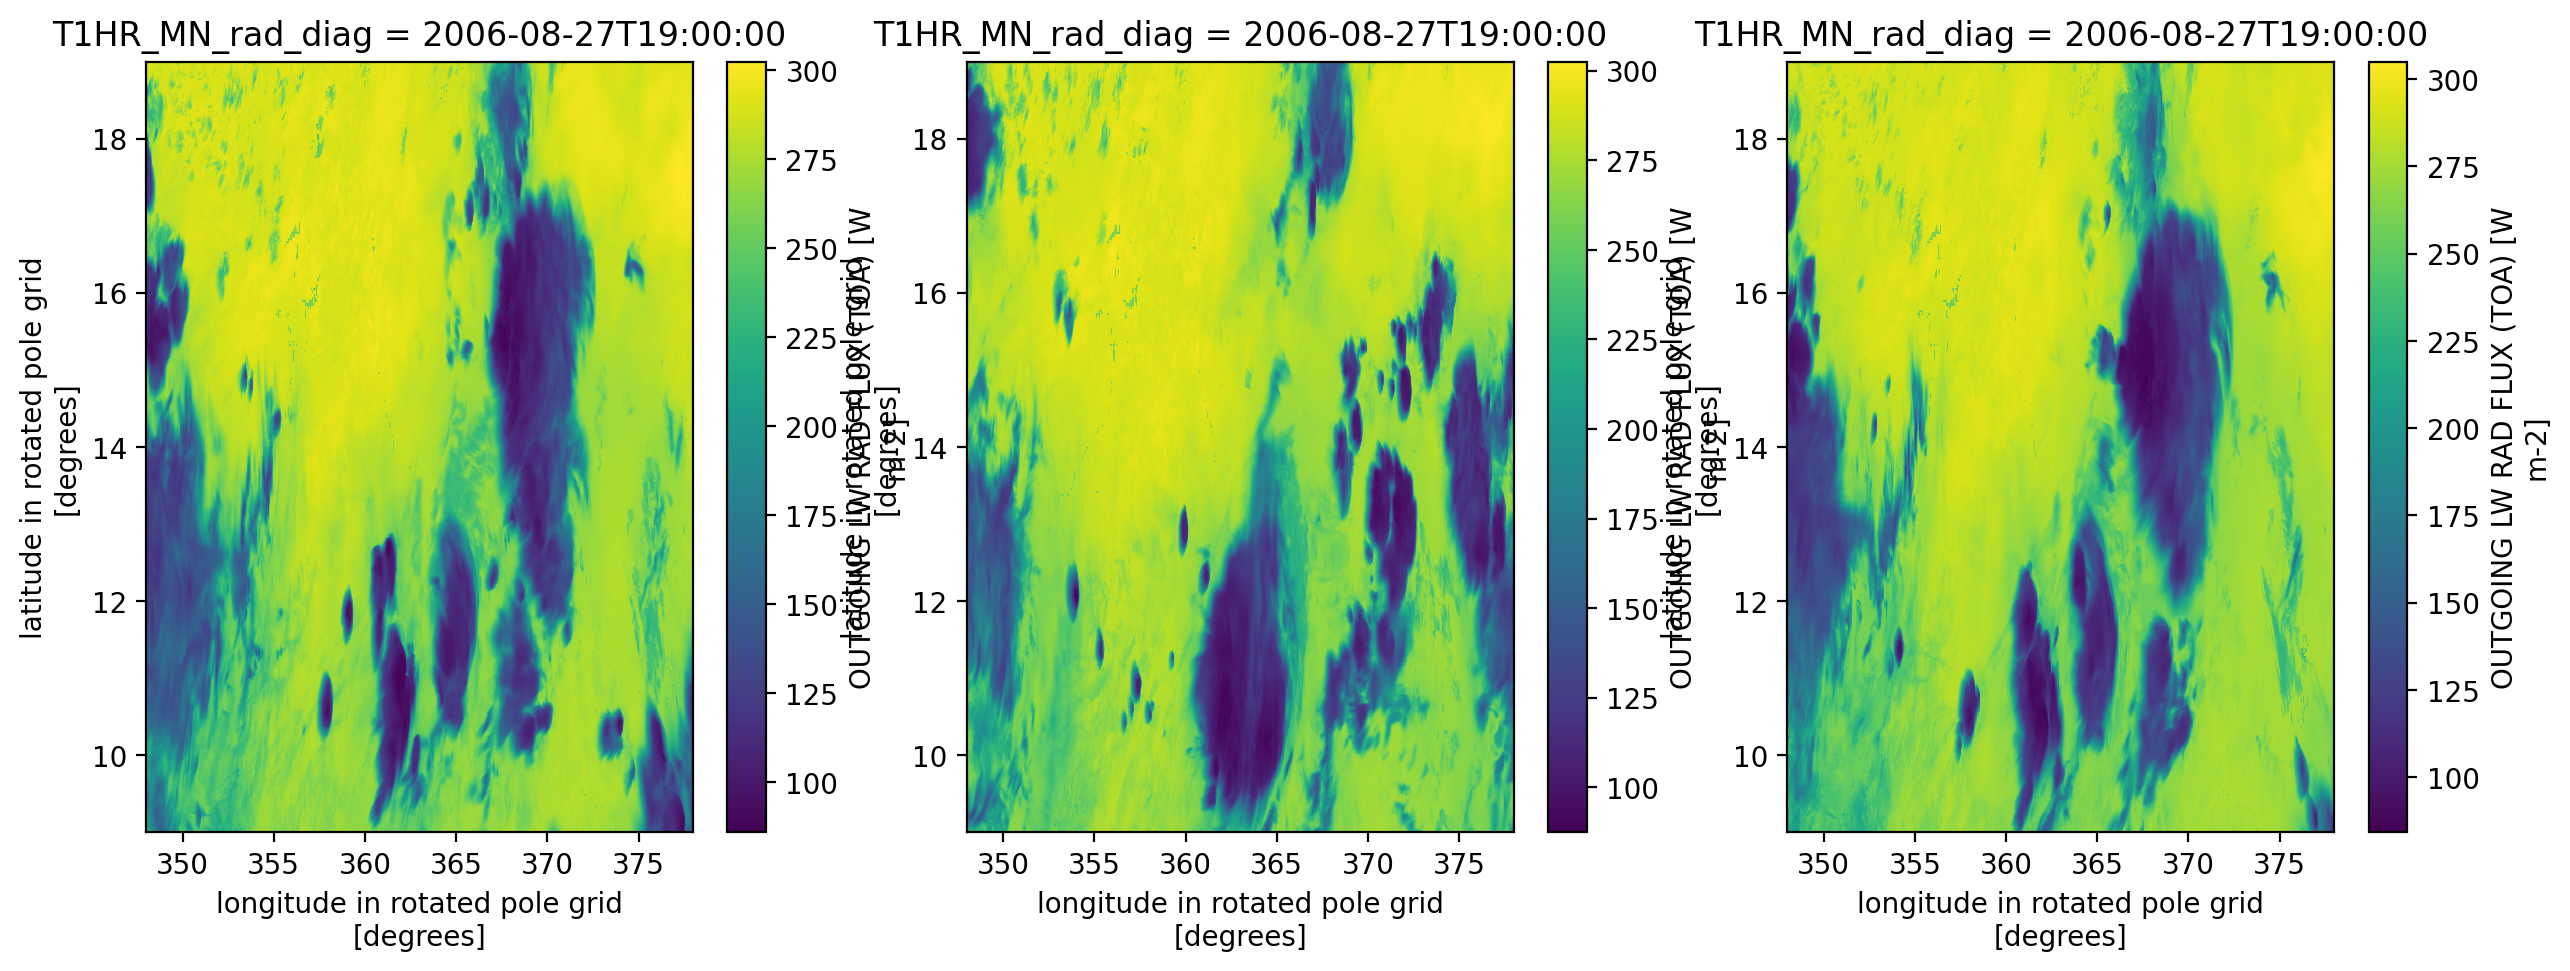

In [37]:
f = plt.figure(figsize=(15,5), dpi=200)
ax = f.add_subplot(1,3,1)

##day1 sensitivity
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("sens",pd.Timestamp("2006-08-27"),19,"surface_vars",stash_dict["olr"])[0,:,:]
example.plot() # note function set to load Sahel subdomain only. Tracking done on full domain.

ax = f.add_subplot(1,3,2)

# day 2 sensitivity
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("sens",pd.Timestamp("2006-08-26"),24+19,"surface_vars",stash_dict["olr"])[0,:,:]
example.plot() # note function set to load Sahel 

ax = f.add_subplot(1,3,3)
# control time starts on 25/07
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("control",pd.Timestamp("2006-08-27"),19,"surface_vars",stash_dict["olr"])[0,:,:]
example.plot() # note function set to load Sahel subdomain only. Tracking done on full domain.

Reading /gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/20060827T0600Z/u-de722/20060827T0600Z/Sahel/1p5km/RA3/um/soil_moistures_20060827_T18.nc
Reading /gws/nopw/j04/lmcs/sensitivity_runs_wg_mcs/20060826T0600Z/u-de721/20060827T0600Z/Sahel/1p5km/RA3/um/soil_moistures_20060827_T18.nc
Reading /gws/nopw/j04/lmcs/u-cy045_control_run/u-cy045/20060827T0000Z/Sahel/1p5km/RA3/um/soil_moistures_20060827_T18.nc


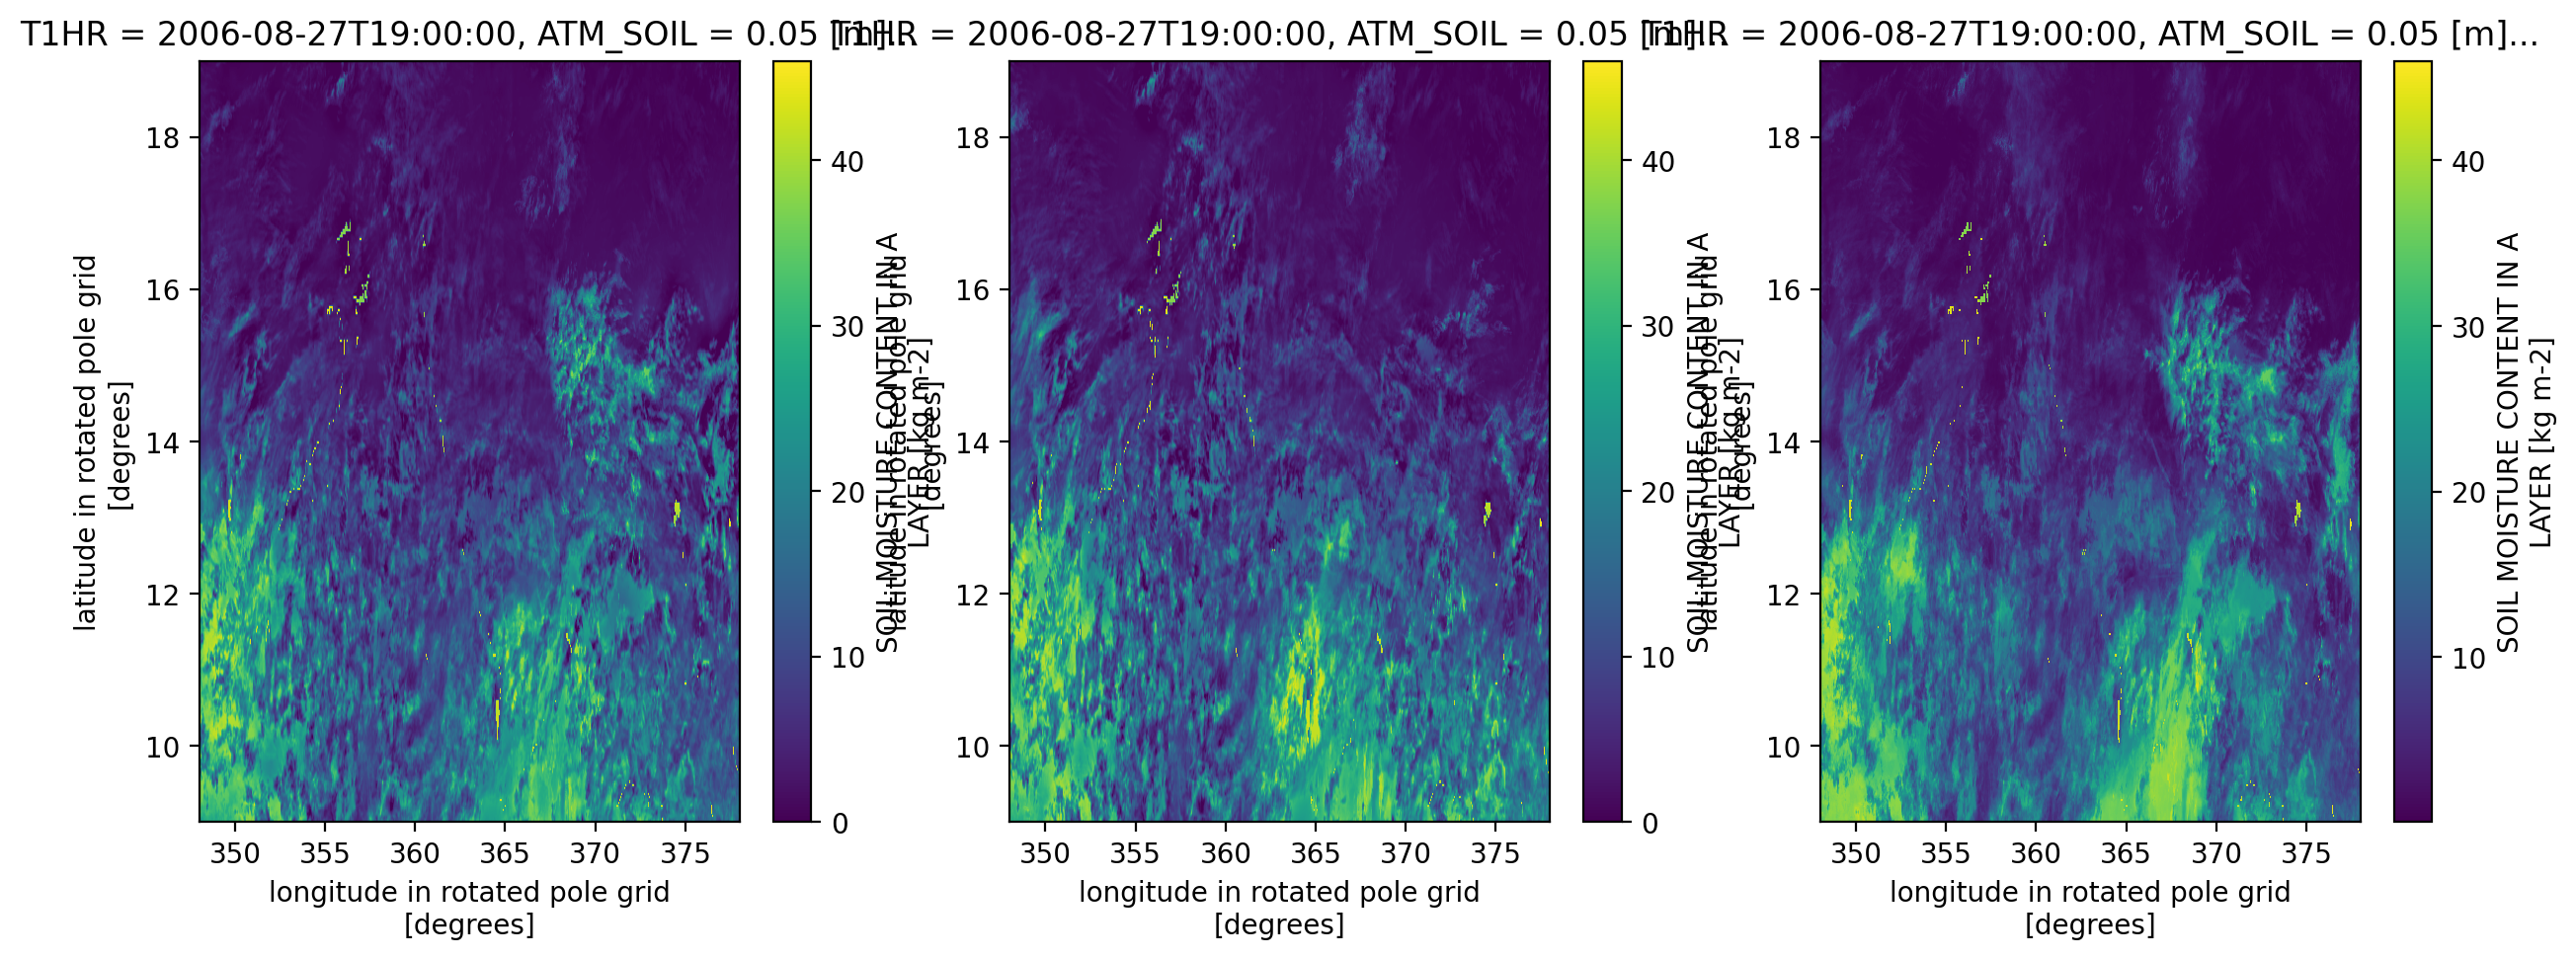

In [39]:
f = plt.figure(figsize=(15,5), dpi=200)
ax = f.add_subplot(1,3,1)

##day1 sensitivity
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("sens",pd.Timestamp("2006-08-27"),19,"soil_moistures",stash_dict["sm"])[0,:,:]
example.plot() # note function set to load Sahel subdomain only. Tracking done on full domain.

ax = f.add_subplot(1,3,2)

# day 2 sensitivity
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("sens",pd.Timestamp("2006-08-26"),24+19,"soil_moistures",stash_dict["sm"])[0,:,:]
example.plot() # note function set to load Sahel 

ax = f.add_subplot(1,3,3)
# control time starts on 25/07
# get soil moisture field from sensitivity run at 18UTC on day 1 - would do hour=42 for 18UTC on day 2.
example=load_file("control",pd.Timestamp("2006-08-27"),19,"soil_moistures",stash_dict["sm"])[0,:,:]
example.plot() # note function set to load Sahel subdomain only. Tracking done on full domain.